### Необходимые библиотеки

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import re
import warnings
warnings.filterwarnings('ignore')

2025-06-19 17:57:28.223578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750355848.454662      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750355848.518615      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Анализ и очистка данных

In [2]:
data = pd.read_csv('/kaggle/input/reviews/reviews.csv',sep = '\t')
data.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [3]:
print(f'Данные представляют собой {data.shape[0]} строк с {data.shape[1]} признаками')

Данные представляют собой 90000 строк с 2 признаками


In [4]:
# Проверка на пропущенные значения
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Text(0.5, 1.0, 'Sentiment data destribution')

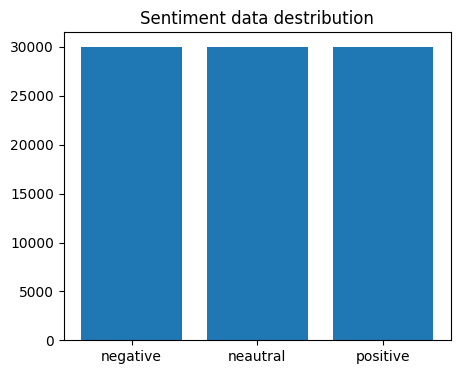

In [5]:
# Проверка распределения данных
values = data['sentiment'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(values.index, values.values)
plt.title('Sentiment data destribution')

In [6]:
data['review'].duplicated().sum()

2679

In [7]:
data.drop_duplicates(subset="review", keep="first", inplace=True)
data.shape

(87321, 2)

In [20]:
data['text_length'] = data['review'].apply(lambda x: len(x.split()))

In [21]:
data['text_length'].max()

154

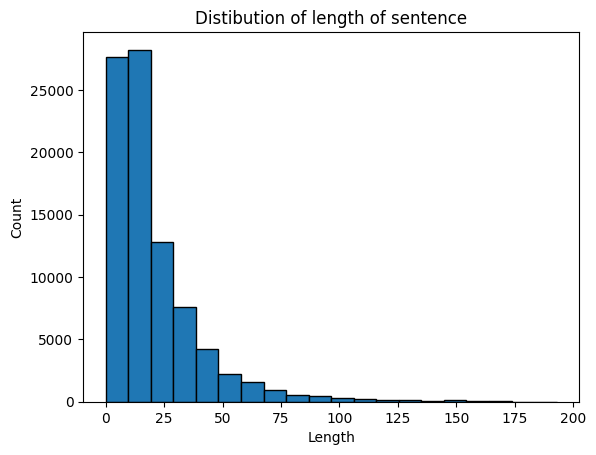

In [11]:
# Проверка распределения длинны отзывов
data['text_length'].plot(kind='hist', bins=20, edgecolor='black')

plt.title('Distibution of length of sentence')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [9]:
# Приводим все строки к нижнему регистру
data['review'] = data['review'].str.lower()

In [10]:
# Удаляем очень короткие отзывы, длинной меньше 3 символов
data = data[data['text_length'] > 3]  
data.drop(columns='text_length', inplace=True)

In [11]:
# удаляем слова не несущие смысловой нагрузки
russian_stopwords = set(stopwords.words('russian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in russian_stopwords])

data['review'] = data['review'].apply(remove_stopwords)

In [12]:
has_urls = data['review'].str.contains(r'http[s]?://|www\.', regex=True)
print(f"Отзывов с URL: {has_urls.sum()}")

Отзывов с URL: 125


In [13]:
has_emails = data['review'].str.contains(r'\S+@\S+\.\S+', regex=True)
print(f"Отзывов с email: {has_emails.sum()}")

Отзывов с email: 5


In [14]:
has_usernames = data['review'].str.contains(r'@\w+', regex=True)
print(f"Отзывов с @username: {has_usernames.sum()}")

Отзывов с @username: 22


In [15]:
has_specials = data['review'].str.contains(r'[^а-яА-Яa-zA-Z0-9\s]', regex=True)
print(f"Отзывов со спецсимволами: {has_specials.sum()}")

Отзывов со спецсимволами: 78914


In [16]:
# очистка данных от 
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Удаление ссылок
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)  # Email
    text = re.sub(r"@\w+", "", text)     # Удаление @username
    text = re.sub(r"[^а-яА-ЯёЁa-zA-Z0-9\s]", " ", text)  # Удаление спецсимволов
    text = re.sub(r"\s+", " ", text)     # Замена множественных пробелов на один
    return text.strip()
    
data['review'] = data['review'].apply(clean_text)

In [18]:
print(f'После очистки количество строк уменьшилось до {data.shape[0]}')

После очистки количество строк уменьшилось до 82363


In [21]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [22]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 6.3 MB/s eta 0:00:0000:0100:010m
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [23]:
import spacy 

# Загружаем предобученную модель spaCy для русского языка
nlp = spacy.load("ru_core_news_sm")

# Функция для лемматизации входного текста
def lemmatize_spacy(text):
    doc = nlp(text)  # Преобразуем текст в документ spaCy
    return ' '.join([token.lemma_ for token in doc])  # Объединяем леммы всех токенов в строку

data['review'] = data['review'].apply(lemmatize_spacy)

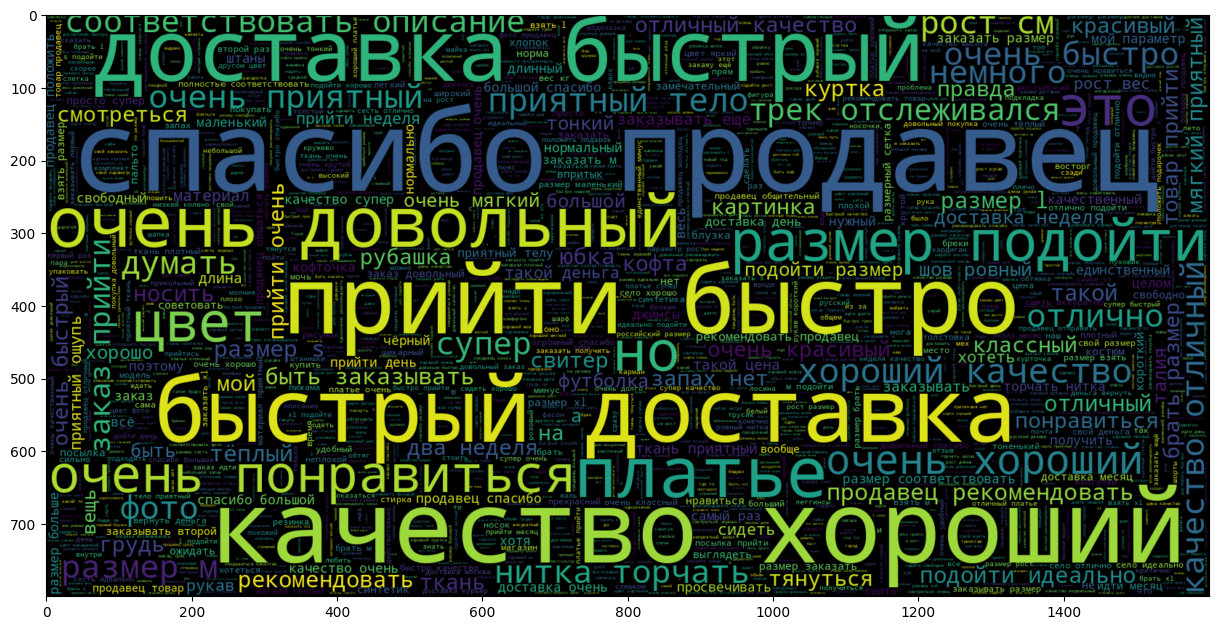

In [24]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data['sentiment'] == 'positive']['review']))
plt.imshow(wc , interpolation = 'bilinear')

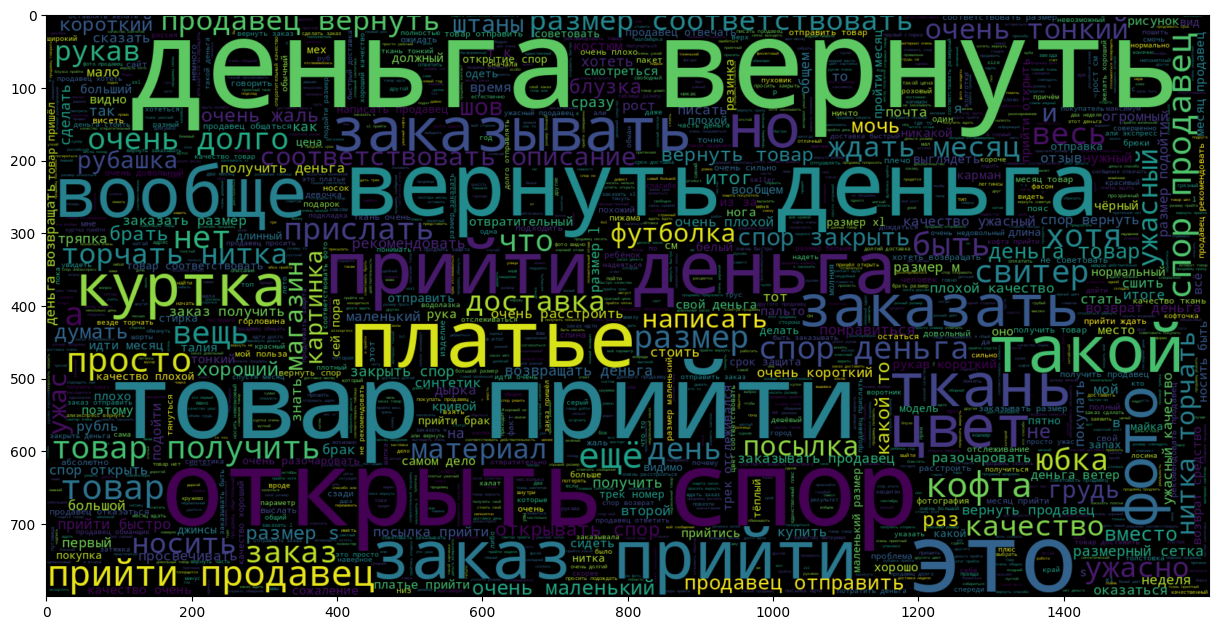

In [25]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data['sentiment'] == 'negative']['review']))
plt.imshow(wc , interpolation = 'bilinear')

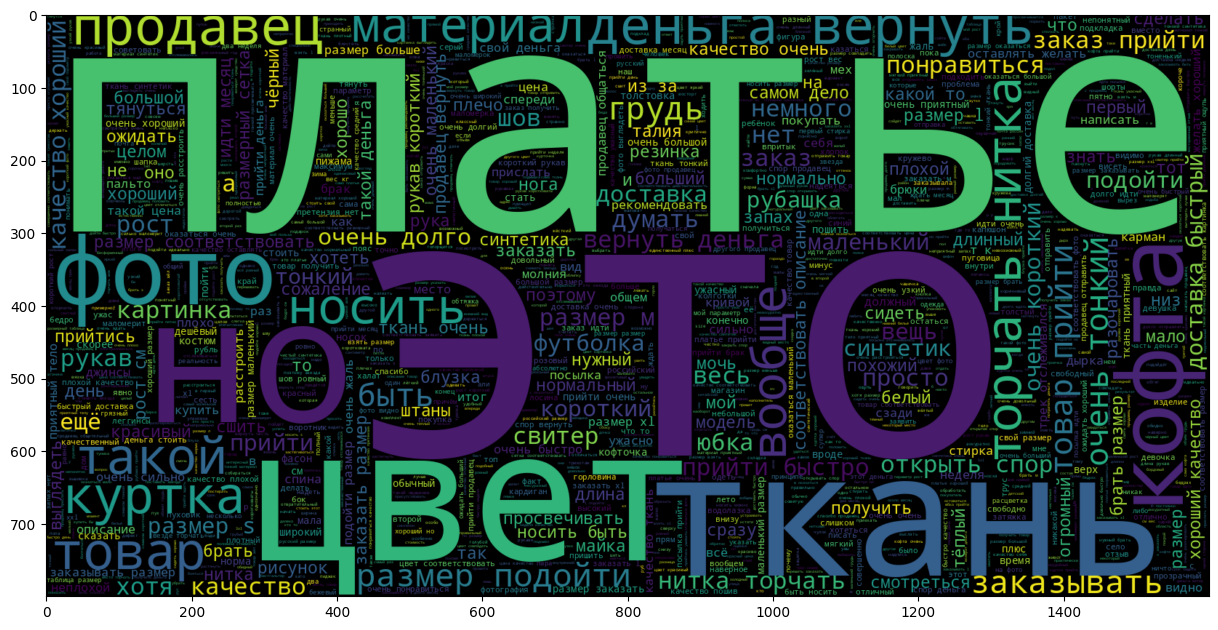

In [26]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data['sentiment'] == 'neautral']['review']))
plt.imshow(wc , interpolation = 'bilinear')

## Train test split

In [27]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000  # Максимальное количество уникальных слов в словаре
MAX_SEQUENCE_LENGTH = 100  # Максимальная длина текста 

In [28]:
train_data, test_data = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 65764
Test Data size 16442


In [29]:
train_data.head(10)

,review,sentiment
66460,блузка просто класс идти месяц стоить,positive
24685,рубашка сшить понятно кто размер вроде подойти...,negative
71437,куртка понравиться хороший качество фото похож...,positive
32080,размер 44 нужный брать минимум м ку,neautral
50051,товар дойти два половиной неделя правда рваный,neautral
31159,синтетика скатывается 2 день носок,neautral
51330,вообще общий фотография продавец джинсы джинсы...,neautral
32967,размер соответствовать в лодыжка узкий очень с...,neautral
68813,москва 18 день отслеживалась кинуть почтовый я...,positive
87123,тянуться удобные цвет соответствовать подарок ...,positive


### Токенизация

In [30]:
tokenizer = Tokenizer()  
tokenizer.fit_on_texts(train_data['review'])  

word_index = tokenizer.word_index  
vocab_size = len(tokenizer.word_index) + 1  
print("Vocabulary Size :", vocab_size)  

Vocabulary Size : 32953


In [31]:
# Преобразуем отзывы в числовые последовательности и дополняем/усекаем их до фиксированной длины
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (65764, 100)
Testing X Shape: (16442, 100)


In [32]:
labels = train_data['sentiment'].unique().tolist()

In [33]:
encoder = LabelEncoder()  
encoder.fit(train_data['sentiment'].to_list())  

y_train = encoder.transform(train_data['sentiment'].to_list())
y_test = encoder.transform(test_data['sentiment'].to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (65764, 1)
y_test shape: (16442, 1)


### Архитектура модели и обучение

In [98]:
EMBEDDING_DIM = 100  # Размерность эмбеддингов слов 
LR = 1e-3  # Скорость обучения 
BATCH_SIZE = 256  # Размер батча 
EPOCHS = 10  # Количество эпох обучения 
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'  # Путь для сохранения лучшей версии модели

In [99]:
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True  
)

In [101]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')  

embedding_sequences = embedding_layer(sequence_input)  

x = SpatialDropout1D(0.3)(embedding_sequences)  

x = LSTM(
    128,                      # Количество нейронов в LSTM-слое
    dropout=0.3,              # Dropout внутри LSTM 
    kernel_regularizer=l2(0.001)  # L2-регуляризация 
)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# Полносвязный слой на 128 нейронов с ReLU и L2-регуляризацией

x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=outputs)

In [102]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  
    loss='sparse_categorical_crossentropy',                  
    metrics=['accuracy']                                   
)

ReduceLROnPlateau = ReduceLROnPlateau(
    factor=0.1,             
    min_lr=0.01,            
    monitor='val_loss',     
    verbose=1              
)

In [48]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


I0000 00:00:1750240778.550352      35 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [103]:
early_stop = EarlyStopping(
    monitor='val_loss',            
    patience=3,                    # Прерываем обучение, если 3 эпохи подряд нет улучшений
    restore_best_weights=True,    # Восстанавливаем веса с лучшей эпохи
    verbose=1                      
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,             # Уменьшаем learning rate в 2 раза
    patience=2,             # Если 2 эпохи подряд нет улучшения — снижаем LR
    min_lr=1e-5,            # Минимально допустимая скорость обучения
    verbose=1               
)

# Обучение модели
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test), 
    batch_size=128,
    epochs=20,
    callbacks=[early_stop, reduce_lr]  
)

Epoch 1/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5599 - loss: 1.0752 - val_accuracy: 0.7122 - val_loss: 0.7168 - learning_rate: 3.0000e-04
Epoch 2/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7225 - loss: 0.6957 - val_accuracy: 0.7270 - val_loss: 0.6642 - learning_rate: 3.0000e-04
Epoch 3/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7486 - loss: 0.6319 - val_accuracy: 0.7266 - val_loss: 0.6520 - learning_rate: 3.0000e-04
Epoch 4/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7667 - loss: 0.5855 - val_accuracy: 0.7278 - val_loss: 0.6417 - learning_rate: 3.0000e-04
Epoch 5/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7802 - loss: 0.5602 - val_accuracy: 0.7273 - val_loss: 0.6463 - learning_rate: 3.0000e-04
Epoch 6/20
511/514 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7935 - loss: 0.5336
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
514/514 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accurac

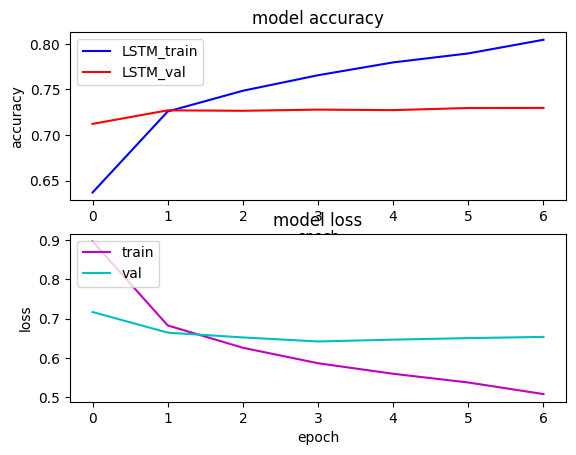

In [104]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')